# WGAN_GP MNIST

This notebook is for implementing `Wasserstein GAN-Gradient Panelty (WGAN_GP)` from the paper [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections), [Jonathan Hui's Blog](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
algorithm = 'WGAN_GP_MNIST'

img_size   = 28

batch_size = 64
num_epoch  = 50

n_latent = 100

beta1 = 0
beta2 = 0.9

learning_rate_g = 0.0001
learning_rate_d = 0.0001

show_result_epoch = 5

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_WGAN_GP_MNIST/model/model" 

# WGAN_GP Parateter
n_critic = 1
d_lambda = 10 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 7*7*1024], initializer=xavier_init)
        b1 = tf.get_variable('b1', [7*7*1024], initializer=xavier_init)
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 1024))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1, kernel_initializer=xavier_init)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [8]:
def GAN(x, z, is_training):
    # Generator
    G = Generator(z, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, is_training, reuse=True)
    
    # get loss 
    ########################################### WGAN GP ###########################################
    eps = tf.random_uniform(shape=tf.shape(x),minval=0.0, maxval=1.0)
    x_hat = (eps * x) + ((1-eps) * G)
    D_hat, _ = Discriminator(x_hat, is_training, reuse=True)
    grad = tf.gradients(D_hat, [x_hat])[0]
    GP = d_lambda * tf.square(tf.norm(grad, ord=2) - 1)
    
    d_loss = -tf.reduce_mean(D_logit_real) + tf.reduce_mean(D_logit_fake) + GP
    g_loss = -tf.reduce_mean(D_logit_fake) 
    ###############################################################################################

    return d_loss, g_loss, G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d, beta1, beta2).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g, beta1, beta2).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [ ]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: -1.62944 / D Loss: 0.79649


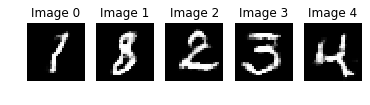

Epoch: 2 / G Loss: -1.46492 / D Loss: 0.74151
Epoch: 3 / G Loss: -1.18724 / D Loss: 0.84228
Epoch: 4 / G Loss: -0.96359 / D Loss: 0.90265
Epoch: 5 / G Loss: -0.85765 / D Loss: 0.91554


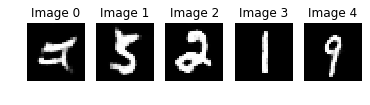

Epoch: 6 / G Loss: -0.88647 / D Loss: 0.88533
Epoch: 7 / G Loss: -0.70785 / D Loss: 0.90547
Epoch: 8 / G Loss: -0.68087 / D Loss: 0.89776
Epoch: 9 / G Loss: -0.92192 / D Loss: 0.90113
Epoch: 10 / G Loss: -0.78550 / D Loss: 0.77135


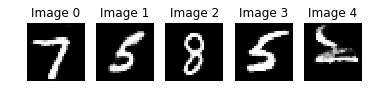

Epoch: 11 / G Loss: -0.66251 / D Loss: 0.79097
Epoch: 12 / G Loss: -0.64042 / D Loss: 0.85479
Epoch: 13 / G Loss: -0.61477 / D Loss: 0.73297
Epoch: 14 / G Loss: -0.64609 / D Loss: 0.85537
Epoch: 15 / G Loss: -0.64114 / D Loss: 0.92180


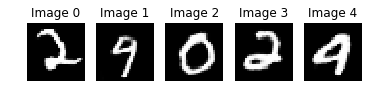

Epoch: 16 / G Loss: -0.53677 / D Loss: 0.67377
Epoch: 17 / G Loss: -0.56631 / D Loss: 0.69013
Epoch: 18 / G Loss: -0.55932 / D Loss: 0.93784
Epoch: 19 / G Loss: -0.70444 / D Loss: 0.82597
Epoch: 20 / G Loss: -0.44856 / D Loss: 0.87988


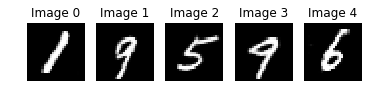

Epoch: 21 / G Loss: -0.63634 / D Loss: 0.86060
Epoch: 22 / G Loss: -0.57229 / D Loss: 0.76459
Epoch: 23 / G Loss: -0.24838 / D Loss: 0.88559
Epoch: 24 / G Loss: -0.54387 / D Loss: 1.01582
Epoch: 25 / G Loss: -0.42747 / D Loss: 0.85571


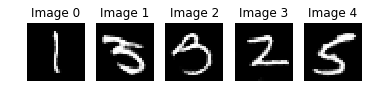

Epoch: 26 / G Loss: -0.11469 / D Loss: 0.84010
Epoch: 27 / G Loss: -0.58286 / D Loss: 0.66911
Epoch: 28 / G Loss: -0.18663 / D Loss: 1.06307
Epoch: 29 / G Loss: -0.63823 / D Loss: 0.98817
Epoch: 30 / G Loss: -0.27712 / D Loss: 0.79499


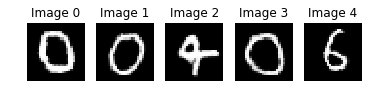

Epoch: 31 / G Loss: -0.43570 / D Loss: 0.80832
Epoch: 32 / G Loss: -0.38540 / D Loss: 0.86206
Epoch: 33 / G Loss: -0.37699 / D Loss: 0.87056
Epoch: 34 / G Loss: -0.25752 / D Loss: 1.03787
Epoch: 35 / G Loss: 0.13506 / D Loss: 0.82616


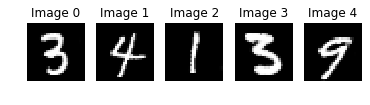

Epoch: 36 / G Loss: -0.23106 / D Loss: 0.75532
Epoch: 37 / G Loss: -0.24361 / D Loss: 0.76778
Epoch: 38 / G Loss: -0.08059 / D Loss: 0.93509
Epoch: 39 / G Loss: -0.39276 / D Loss: 0.93896
Epoch: 40 / G Loss: -0.33909 / D Loss: 0.90729


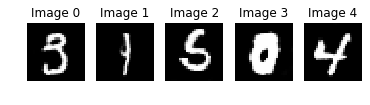

Epoch: 41 / G Loss: -0.33547 / D Loss: 0.65333
Epoch: 42 / G Loss: -0.38235 / D Loss: 0.81878
Epoch: 43 / G Loss: -0.24610 / D Loss: 0.75616
Epoch: 44 / G Loss: -0.20341 / D Loss: 1.02102
Epoch: 45 / G Loss: -0.01807 / D Loss: 0.97392


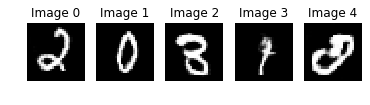

Epoch: 46 / G Loss: -0.47904 / D Loss: 0.67215
Epoch: 47 / G Loss: -0.38656 / D Loss: 0.90133
Epoch: 48 / G Loss: -0.60181 / D Loss: 0.71048
Epoch: 49 / G Loss: -0.25816 / D Loss: 0.83003
Epoch: 50 / G Loss: -0.34854 / D Loss: 0.77147


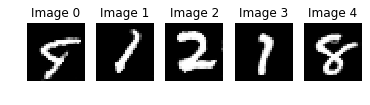

In [11]:
if train_model:
    # Training
    data_x = x_train
    len_data = x_train.shape[0]

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(data_x)

        # Making mini-batch
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                data_x_in = data_x[j : j + batch_size, :]
            else:
                data_x_in = data_x[j : len_data, :]

            data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))

            sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))

            # Run Optimizer!
            G_out = sess.run(G, feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

            ########################################### WGAN ###########################################
            for iter_d in range(n_critic):
                _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
            ############################################################################################

            _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

            print("Batch: {} / {}".format(j, len_data), end="\r")

        # Print Progess
        print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

        # Show test images 
        z_test = np.random.uniform(-1, 1, size=(5, n_latent))
        G_out = sess.run(G, feed_dict = {z: z_test, is_training: False})

        if i == 0 or (i+1) % show_result_epoch == 0:
            f, ax = plt.subplots(1,5)
            for j in range(5):
                ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

        plt.show()

## Image Generation

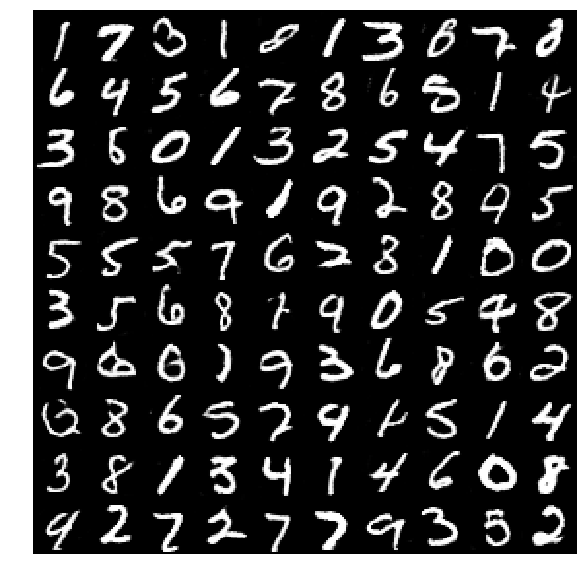

In [15]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result, is_training: False})

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = G_result[i,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))